# NFL Fantasy Football Project

It's Monday night, I have just gotten off of a long day at work, and the anxiety has been building all day. I pick up my phone and open up the ESPN fantasy football app (where I have hosted my fantasy football league, affectionately dubbed "The League" as an homage to one of our favorite football themed sitcoms, for over ten years) and I click on my matchup. I'm down 15 points and I have one wide receiver left who is playing in the Monday night game. Can he get the 15 points I need to secure the win this week? Or will all my anticipation lead to dissapointment as I head to sleep and into the waiver wire section of the week? If you're a fantasy football fan, you know that this question almost always leads to dissapointment (although from a statistical standpoint that is liekly not true).

This is the situation I have found myself in many times over the years. As a fantasy football fanatic, I cannot get enough of the highs (and lows) the game has to offer. However, wouldn't those highs and lows be a bit higher if I could know with more certainty how my team would perform? What if I could improve upon the already fairly robust fantasy projection systems most major fantasy apps have? This is the quest of this project!

The goal is to create an app/dashboard with all the information I need to dominate my league. Projections, historical data, vizualizations, and potential sleepers will all be located in one, easy to use interface. If I'm feeling generous I may even share this useful tool with my league-mates!

## This Notebook - EDA and Feature Engineering
The point of this notebook is to introduce the data I'll be using for this project. I want to explore the data, visualize it, clean it, and engineer some features of interest! Data comes from the [NFL Data API](https://github.com/cooperdff/nfl_data_py/tree/main) which not only contains play-by-play data from every NFL game, but also compiles statistics and metrics from other popular NFL stat gathering sources (such as AWS).

In [124]:
import nfl_data_py as nfl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from dotenv import load_dotenv
import os
import requests

load_dotenv()


sns.set_theme()
# 2015 is an arbitrary starting year, we could include more data in the future
year = [2015, 2017, 2016, 2018, 2019, 2020, 2021, 2022, 2023]
export = False

## Messing Around

This is where we just try to explore the data and get new features, this is all formalized in the above section.

### Data Imports and Brief Exploration

Import all the data we will need from the nfl data api

In [56]:
# this maps player ID's from accross multiple platforms. There is also associated player information like Name, College, etc.
id_map = nfl.import_ids()

# we want to have depth charts as depth is likely a good predictor of fantasy value. 1st string is utilized more than 3rd string
depth_charts = nfl.import_depth_charts(years=year)

# importing next gen stats data from AWS
ngs_receiving = nfl.import_ngs_data(stat_type="receiving", years=year).drop_duplicates()

# pro football reference stats
# there is no data prior to 2018 for PFR
pfr_receiving = nfl.import_weekly_pfr(s_type="rec", years=[y for y in year if y > 2017]).drop_duplicates()

# # weekly aggregate stats
weekly = nfl.import_weekly_data(years=year, downcast=True).drop_duplicates()
# I need to standardize the game ID and player ID's accross the dataframes
matchup_data = nfl.import_schedules(year)

# grab play-by-play data to synthesize some base stats. Adding in stats from other platforms after the fact.
pbp_data = nfl.import_pbp_data(years=year)

# importing rushing next gen stats data
ngs_rush = nfl.import_ngs_data(stat_type="rushing", years=year).drop_duplicates()

# rushing pro football reference stats
pfr_rush = nfl.import_weekly_pfr(s_type="rush", years=[y for y in year if y > 2017]).drop_duplicates()

# importing injuries
injuries = nfl.import_injuries(years=year)

Downcasting floats.
2015 done.
2017 done.
2016 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [57]:
# What data appears in each dataset?
print(
    textwrap.fill(
        f"We have the following columns in the IDs dataset: {*id_map.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the IDs dataset: ('mfl_id', 'sportradar_id', 'fantasypros_id', 'gsis_id', 'pff_id',
 'sleeper_id', 'nfl_id', 'espn_id', 'yahoo_id', 'fleaflicker_id', 'cbs_id', 'pfr_id', 'cfbref_id', 'rotowire_id',
 'rotoworld_id', 'ktc_id', 'stats_id', 'stats_global_id', 'fantasy_data_id', 'swish_id', 'name', 'merge_name',
 'position', 'team', 'birthdate', 'age', 'draft_year', 'draft_round', 'draft_pick', 'draft_ovr', 'twitter_username',
 'height', 'weight', 'college', 'db_season')


In [58]:
print(
    textwrap.fill(
        f"We have the following columns in the depth charts dataset: {*depth_charts.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the depth charts dataset: ('season', 'club_code', 'week', 'game_type', 'depth_team',
 'last_name', 'first_name', 'football_name', 'formation', 'gsis_id', 'jersey_number', 'position', 'elias_id',
 'depth_position', 'full_name')


In [59]:
print(
    textwrap.fill(
        f"We have the following columns in the Next Gen Stats dataset: {*ngs_receiving.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Next Gen Stats dataset: ('season', 'season_type', 'week', 'player_display_name',
 'player_position', 'team_abbr', 'avg_cushion', 'avg_separation', 'avg_intended_air_yards',
 'percent_share_of_intended_air_yards', 'receptions', 'targets', 'catch_percentage', 'yards', 'rec_touchdowns',
 'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation', 'player_gsis_id', 'player_first_name', 'player_last_name',
 'player_jersey_number', 'player_short_name')


In [60]:
print(
    textwrap.fill(
        f"We have the following columns in the Pro Football Reference dataset: {*pfr_receiving.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Pro Football Reference dataset: ('game_id', 'pfr_game_id', 'season', 'week',
 'game_type', 'team', 'opponent', 'pfr_player_name', 'pfr_player_id', 'rushing_broken_tackles',
 'receiving_broken_tackles', 'passing_drops', 'passing_drop_pct', 'receiving_drop', 'receiving_drop_pct',
 'receiving_int', 'receiving_rat')


In [61]:
print(
    textwrap.fill(
        f"We have the following columns in the weekly stats dataset: {*weekly.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the weekly stats dataset: ('player_id', 'player_name', 'player_display_name',
 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team',
 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets',
 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr',
 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr')


In [62]:
print(
    textwrap.fill(
        f"We have the following columns in the play-by-play dataset: {*pbp_data.columns.tolist(),}",
        width=130,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the play-by-play dataset: ('play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date',
 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp',
 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle',
 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result',
 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score',
 'defteam_score', 'score_differentia

In [63]:
print(
    textwrap.fill(
        f"We have the following columns in the Next Gen Stats (rushing) dataset: {*ngs_rush.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Next Gen Stats (rushing) dataset: ('season', 'season_type', 'week',
 'player_display_name', 'player_position', 'team_abbr', 'efficiency', 'percent_attempts_gte_eight_defenders',
 'avg_time_to_los', 'rush_attempts', 'rush_yards', 'expected_rush_yards', 'rush_yards_over_expected', 'avg_rush_yards',
 'rush_yards_over_expected_per_att', 'rush_pct_over_expected', 'rush_touchdowns', 'player_gsis_id', 'player_first_name',
 'player_last_name', 'player_jersey_number', 'player_short_name')


In [64]:
print(
    textwrap.fill(
        f"We have the following columns in the Pro Football Reference (rushing) dataset: {*pfr_rush.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Pro Football Reference (rushing) dataset: ('game_id', 'pfr_game_id', 'season',
 'week', 'game_type', 'team', 'opponent', 'pfr_player_name', 'pfr_player_id', 'carries', 'rushing_yards_before_contact',
 'rushing_yards_before_contact_avg', 'rushing_yards_after_contact', 'rushing_yards_after_contact_avg',
 'rushing_broken_tackles', 'receiving_broken_tackles')


In [65]:
# let's check out some of the data issues I noticed
# there are some non-stadard team abbreviations in this dataset such as GBP and SDC.
print(
    textwrap.fill(
        f"Team abbreviations in id map dataset: {*id_map.team.unique().tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

Team abbreviations in id map dataset: ('CHI', 'NEP', 'WAS', 'DEN', 'ATL', 'MIN', 'NOS', 'GBP', 'NYJ', 'ARI', 'BAL',
 'CAR', 'LAR', 'TBB', 'BUF', 'SFO', 'PHI', 'FA', 'TEN', 'SEA', 'MIA', 'KCC', 'LVR', 'NYG', 'JAC', 'LAC', 'CLE', 'IND',
 'PIT', 'DET', 'CIN', 'HOU', 'DAL', 'OAK', 'STL', 'SDC', 'RAM', 'FA*')


In [66]:
# looks like there are no receiving stats for running backs in the Next Gen Stats dataset
# we'll have to synthesize these stats using play-by-play data
ngs_receiving.player_position.unique()

array(['WR', 'TE'], dtype=object)

### Data Cleaning

Let's clean up our datasets for analysis. We want to be sure that all the data we just imported is ready for aggregation and manipulation.

**A Note on Tyler Conklin and Ryan Izzo**

there is an issue with these two players. their gsis_id's are swapped in the play by play data. 

In [67]:
# here are these two players in the id_map
id_map[id_map["gsis_id"].isin(["00-0034439", "00-0034270"])][["gsis_id", "name"]]

,gsis_id,name
2311,00-0034439,Tyler Conklin
2478,00-0034270,Ryan Izzo


In [68]:
# you can see they are labeled oppositely in the PBP data
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034439"]["receiver_player_name"]
    .unique()
    .tolist()
)
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034439"]["posteam"]
    .unique()
    .tolist()
)

['R.Izzo']
['NE']


In [69]:
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034270"]["receiver_player_name"]
    .unique()
    .tolist()
)
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034270"]["posteam"]
    .unique()
    .tolist()
)

['T.Conklin']
['MIN', 'NYJ']


In [70]:
# fixing Conklin/Izzo issue
id_map["gsis_id"] = id_map["gsis_id"].replace(
    {"00-0034439": "00-0034270", "00-0034270": "00-0034439"}
)


This data is compiled from many different sources; thus, names, id's, codes, etc. can vary from platform to platform. Let's make sure that team ID's all look the same.

> Note: The Raiders, Chargers, and Rams have all moved since 2015. So their club codes will be a mixture of the codes from the two cities. For contistencies sake we will map all of them to their current club code. 

In [71]:
# we also need to map non-conventional city abbreviations for consistency
common_club_code_map =     {
        "LVR": "LV",
        "KCC": "KC",
        "NOS": "NO",
        "TBB": "TB",
        "SFO": "SF",
        "NEP": "NE",
        "LAR": "LA",
        "GBP": "GB",
        "JAC": "JAX",
        "OAK":"LV",
        "STL":"LAR",
        "SD":"LAC",
        "SDC":"LAC",
        "RAM":"LAR",
        "LA":"LAR"
    }
id_map["team"] = id_map["team"].replace(common_club_code_map)
depth_charts["club_code"] = depth_charts["club_code"].replace(common_club_code_map)
ngs_receiving["team_abbr"] = ngs_receiving["team_abbr"].replace(common_club_code_map)
pfr_receiving["team"] = pfr_receiving["team"].replace(common_club_code_map)
weekly["recent_team"] = weekly["recent_team"].replace(common_club_code_map)
weekly["opponent_team"] = weekly["opponent_team"].replace(common_club_code_map)
matchup_data["away_team"] = matchup_data["away_team"].replace(common_club_code_map)
matchup_data["home_team"] = matchup_data["home_team"].replace(common_club_code_map)
ngs_rush["team_abbr"] = ngs_rush["team_abbr"].replace(common_club_code_map)
pfr_rush["team"] = pfr_rush["team"].replace(common_club_code_map)
injuries['team'] = injuries['team'].replace(common_club_code_map)

# team pops up in many columns in the pbp_data. not all in the below list are team name columns
# but for those that aren't, the replace just won't do anything. 
for col in [x for x in pbp_data.columns if 'team' in x]:
    pbp_data[col] = pbp_data[col].replace(common_club_code_map)

since we are going to use the game_id as a primary key, we want to add it to the datasets that do not have it

In [72]:
# here we grab unique game id's and home/away teams for each game in the season
game_id_map = pd.concat(
    [
        matchup_data[["game_id", "home_team", "week", "season"]].rename(
            {"home_team": "team_abbr"}, axis=1
        ),
        matchup_data[["game_id", "away_team", "week", "season"]].rename(
            {"away_team": "team_abbr"}, axis=1
        ),
    ],
    ignore_index=False,
)

# merges the AWS data with the game id data from above
ngs_receiving = ngs_receiving.merge(
    game_id_map,
    left_on=["week", "team_abbr", "season"],
    right_on=["week", "team_abbr", "season"],
).rename({"player_gsis_id": "player_id"}, axis=1)

# merges the PFR data with the game id data from above
pfr_receiving = pfr_receiving.merge(
    id_map[["pfr_id", "gsis_id"]], left_on=["pfr_player_id"], right_on=["pfr_id"]
).rename({"gsis_id": "player_id"}, axis=1)

# NOTE: The weekly data does not have the opponent team info for 2022. Thus we would need different logic to grab the game_id.
# We actually end up creating all the stats from this dataset by hand so there is no need.

# merges the depth chart data with the game id data from above
depth_charts = depth_charts.merge(
    game_id_map,
    left_on=["week", "club_code", "season"],
    right_on=["week", "team_abbr", "season"],
)

In [73]:
# columns renames
depth_charts = depth_charts.rename({"club_code": "team"}, axis=1)

Now we are going to fix a few more issues.

1. one-hot encode the two point conversion variable so we can use it to calculate points and eventually train on.
2. remove all NFL playoff games, we only want to train on the regular season since that is what applies to fantasy.
3. Fill null values with 0's  where applicable.
4. split up the list of players on a play into a list instead of a string.
5. restrict our main data (`pbp_data`) to only columns we are concerned with. This will make it easier to look at. 

In [74]:
# since we are going to aggregate the play-by-play data to game-by-game data, we want to fix some features so we can count easier
d = {}
# this just makes a countable two point conversion field. One-hot encoding if you will
d["is_two_point_conversion"] = pbp_data["two_point_conv_result"].apply(
    lambda x: 1 if x == "success" else 0
)
pbp_data = pd.concat([pbp_data, pd.DataFrame(d)], axis=1)



In [75]:
# we're only going to consider the regular season
# NOTE: In 2021, there was an extra regular season game added
t1 = pbp_data[
    (pbp_data.week <= 18)
    & (
        (pbp_data["game_id"].str.contains("2021"))
        | (pbp_data["game_id"].str.contains("2022"))
        | (pbp_data["game_id"].str.contains("2023"))
    )
].copy()
t2 = pbp_data[
    (pbp_data.week <= 17)
    & (
        (pbp_data["game_id"].str.contains("2020"))
        | (pbp_data["game_id"].str.contains("2019"))
        | (pbp_data["game_id"].str.contains("2018"))
        | (pbp_data["game_id"].str.contains("2017"))
        | (pbp_data["game_id"].str.contains("2016"))
        | (pbp_data["game_id"].str.contains("2015"))
    )
].copy()
pbp_data = pd.concat([t1, t2], ignore_index=True)


In [76]:

# just make sure that plays that don't result in a touchdown have data here. Another one-hot (ish)
pbp_data["touchdown"] = pbp_data["touchdown"].fillna(0)
pbp_data["interception"] = pbp_data["interception"].fillna(0)
pbp_data["fumble_lost"] = pbp_data["fumble_lost"].fillna(0)
pbp_data["passing_yards"] = pbp_data["passing_yards"].fillna(0)
pbp_data["pass_touchdown"] = pbp_data["pass_touchdown"].fillna(0)
pbp_data["rushing_yards"] = pbp_data["rushing_yards"].fillna(0)
pbp_data["rush_touchdown"] = pbp_data["rush_touchdown"].fillna(0)
pbp_data["receiving_yards"] = pbp_data["receiving_yards"].fillna(0)


In [77]:
# this creates a list of offensive players rather than a string. This helps later when we look at snaps played by each player
# NOTE: Some of these are missing.
pbp_data["offense_players"] = pbp_data["offense_players"].apply(
    lambda x: x.split(";") if type(x) == str else x
)

In [78]:
# we are also going to restrict to data that we need in the pbp_data, this will make it easier to look at
rel_cols_pbp = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "week",
    "posteam",
    "defteam",
    "yardline_100",
    "game_date",
    "game_seconds_remaining",
    "qtr",
    "down",
    "time",
    "desc",
    "play_type",
    "yards_gained",
    "air_yards",
    "yards_after_catch",
    "score_differential",
    "epa",
    "incomplete_pass",
    "interception",
    "penalty",
    "rush_attempt",
    "pass_attempt",
    "touchdown",
    "pass_touchdown",
    "rush_touchdown",
    "two_point_attempt",
    "fumble",
    "fumbled_1_team",
    "fumbled_1_player_id",
    "fumbled_1_player_name",
    "fumbled_2_player_id",
    "fumbled_2_player_name",
    "fumbled_2_team",
    "fumble_lost",
    "complete_pass",
    "passer_player_id",
    "passer_player_name",
    "passing_yards",
    "receiver_player_id",
    "receiver_player_name",
    "receiving_yards",
    "rusher_player_id",
    "rusher_player_name",
    "rushing_yards",
    "fumbled_1_player_id",
    "fumbled_2_player_id",
    "penalty_player_id",
    "penalty_yards",
    "replay_or_challenge",
    "replay_or_challenge_result",
    "penalty_type",
    "offense_players",
    "players_on_play",
    "timeout",
    "is_two_point_conversion",
    "first_down",
]

pbp_data = pbp_data[rel_cols_pbp].copy()

### Visualize missing info.
Now let's look at the missing information for the play-by-play data.

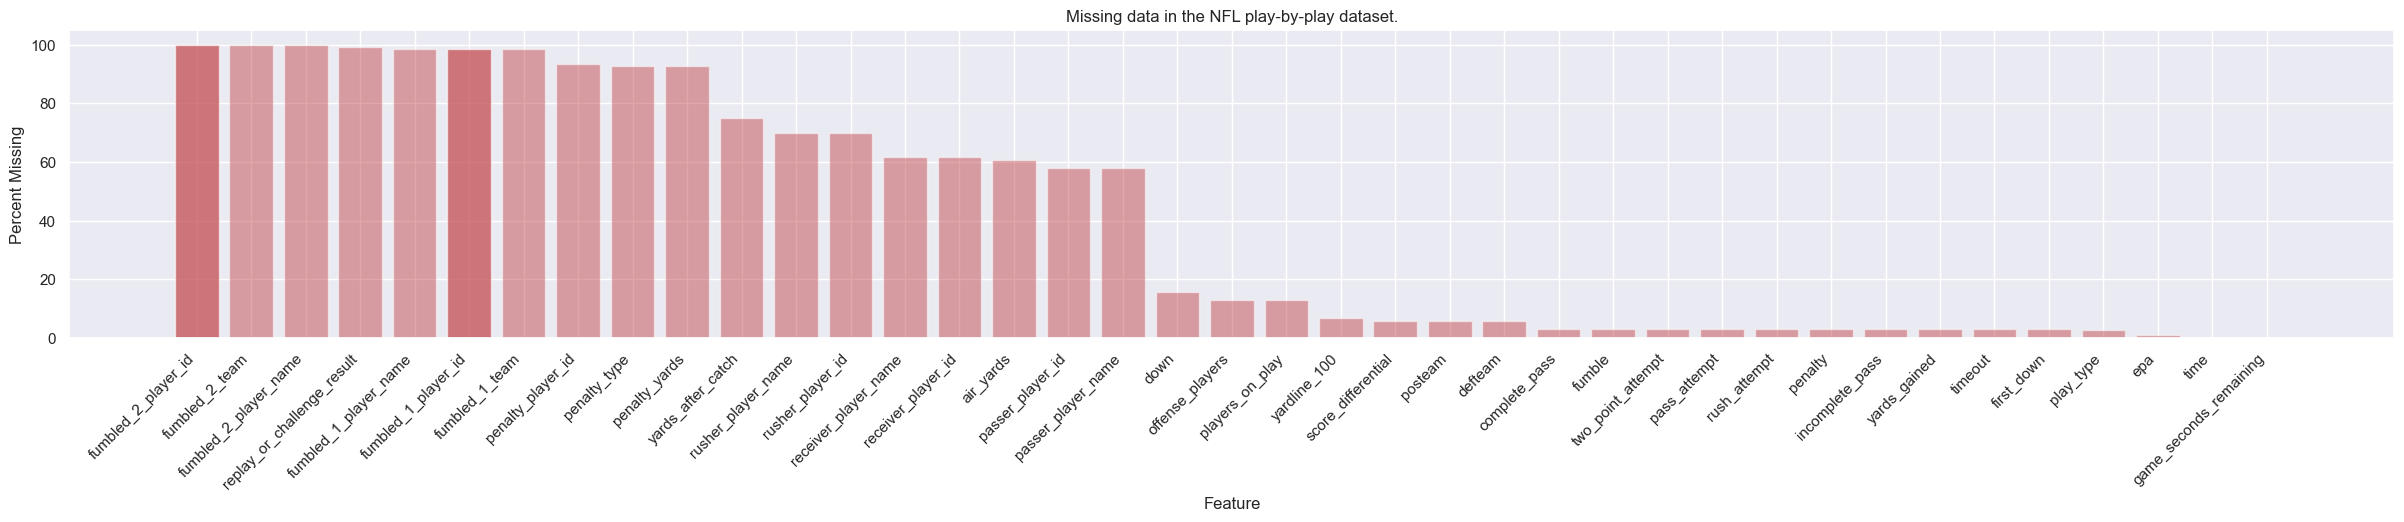

In [79]:
# do we have any missing data?
fig, ax = plt.subplots(figsize=(30, 4))

nan_feats = 100 * pbp_data.isna().sum() / len(pbp_data)
nan_feats_sorted = nan_feats[nan_feats > 0].sort_values(ascending=False)

ax.bar(nan_feats_sorted.index, nan_feats_sorted.values, color="r", alpha=0.5)

ax.set_title("Missing data in the NFL play-by-play dataset.")
ax.set_xlabel("Feature")
ax.set_ylabel("Percent Missing")

# fix tick labels
_ = ax.set_xticks(ax.get_xticks())
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha="right")

# # Make some labels.
# rects = ax.patches
# labels = [f"{perc:.2f}%" for perc in nan_feats_sorted.values]

# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 2, label, ha="center", va="bottom", fontsize='x-small', rotation=90
#     )

# plt.show()

### Issues with `"offense_players"`

We will be wanting to know what players are available on which plays, in order to compute snap percentages, target percentages, targets/snap ratios, etc. There is a field that stores the `"gsis_id"` for each player on offense for each play: `"offense_players"`. Is that field filled out for each play? Let's investigate. 

In [80]:
temp_filter = pbp_data[
    (~pbp_data["play_type"].isin(["kickoff", "extra_point", "field_goal", "punt"]))
    & (~pbp_data["desc"].str.contains("Punt formation"))
    & (~pbp_data["desc"].str.contains(" punts "))
    & (~pbp_data["desc"].str.contains("Kick formation"))
]
print(
    f"""Of the {len(temp_filter):,} relevant plays (relevance to recieving is 
any non-kicking play), {temp_filter.offense_players.isna().sum():,} ({100*temp_filter.offense_players.isna().sum()/len(temp_filter):.1f}%) are missing personnel information."""
)

Of the 349,887 relevant plays (relevance to recieving is 
any non-kicking play), 45,305 (12.9%) are missing personnel information.


In [81]:
# this could affect our snap counts. What do these plays look like?
# how many are timeouts?
num_missing_pers = temp_filter.offense_players.isna().sum()
num_to = temp_filter[
    (temp_filter.offense_players.isna()) & (temp_filter["timeout"] == 1)
]["timeout"].sum()
print(
    f"Of the temp_filter {num_missing_pers:,} plays missing personnel info {num_to:,} are timeouts."
)
remain = num_missing_pers - num_to
# FIXME: you can be more robust here
num_time_marker = len(
    temp_filter[
        (temp_filter.offense_players.isna())
        & (temp_filter["timeout"] != 1)
        & (
            temp_filter["desc"].isin(
                [
                    "GAME",
                    "END GAME",
                    "END QUARTER 1",
                    "END QUARTER 2",
                    "END QUARTER 3",
                    "END QUARTER 4",
                ]
            )
        )
    ]
)

print(
    f"Of the remaining {remain:,} plays, {num_time_marker:,} are entries that denote the beginning/end of the game or a quarter. No plays occur on these entries."
)

Of the temp_filter 45,305 plays missing personnel info 2,263.0 are timeouts.
Of the remaining 43,042.0 plays, 1,516 are entries that denote the beginning/end of the game or a quarter. No plays occur on these entries.


In [82]:
# looks like our snap count info may be off. There are some plays without any personnel info
temp_filter[
    (temp_filter.offense_players.isna())
    & (temp_filter["timeout"] != 1)
    & (
        ~temp_filter["desc"].isin(
            [
                "GAME",
                "END GAME",
                "END QUARTER 1",
                "END QUARTER 2",
                "END QUARTER 3",
                "END QUARTER 4",
            ]
        )
    )
].sample(5)[["desc", "down", "offense_players", "timeout", "players_on_play"]]

,desc,down,offense_players,timeout,players_on_play
135791,(3:05) (Shotgun) 22-C.Edmonds up the middle to...,1.0,NaN,0.0,NaN
148835,(:34) (Shotgun) 9-M.Stafford pass incomplete s...,4.0,NaN,0.0,NaN
141394,(15:00) 15-E.Elliott up the middle to NE 27 fo...,1.0,NaN,0.0,NaN
183963,(9:04) 36-D.Herron left end pushed ob at MIA 2...,3.0,NaN,0.0,NaN
139398,(6:48) 13-B.Purdy pass short right to 44-K.Jus...,2.0,NaN,0.0,NaN


In [83]:
# TODO: justify need to engineer features

### Fumble Lost
Note that the fumble_lost variable only denotes if a fumble was lost on the play, not if the player in consideration (receiver, rusher, QB, etc.) fumbled the ball. Thus, a determination of which player lost the fumble is important for counting the number of fumbles committed by a player.

In [84]:
# let's see if we can get a fumble lost player id
def get_fumble_lost_receiver_id(x, ptype="rec"):
    if ptype == "rec":
        rpid = x["receiver_player_id"]
    elif ptype == "rush":
        rpid = x["rusher_player_id"]
    elif ptype == "pass":
        rpid = x["passer_player_id"]

    fpid1 = x["fumbled_1_player_id"].values[0]
    fpid2 = x["fumbled_2_player_id"].values[0]
    fteam1 = x["fumbled_1_team"]
    fteam2 = x["fumbled_2_team"]

    if fpid1 is None:
        fpid1 = ""

    if fpid2 is None:
        fpid2 = ""

    if fteam1 is None:
        fteam1 = ""

    if fteam2 is None:
        fteam2 = ""

    offense = x["posteam"]
    # if there was a fumble and the receiver we are looking at was one of the fumble players
    if x["fumble_lost"] == 1 and (fpid1 == rpid or fpid2 == rpid):
        # the only time this is not a fumble for the player in consideration is when
        # there are two fumbles by the offense and the second player is not the first player.
        # e.g. player 1 fumbled and it was picked up by teammate player 2, then player 2 fumbles
        # and it is recovered by the defense
        if (fpid1 == rpid and fpid2 != rpid) and (
            fteam1 == offense and fteam2 == offense
        ):
            return 0
        else:
            return 1
    else:
        return 0


# now just grab fumbles for each position on each play.
pbp_data["receiver_fumble_lost"] = pbp_data.apply(
    lambda x: get_fumble_lost_receiver_id(x, ptype="rec"), axis=1
)
pbp_data["rusher_fumble_lost"] = pbp_data.apply(
    lambda x: get_fumble_lost_receiver_id(x, ptype="rush"), axis=1
)
pbp_data["passer_fumble_lost"] = pbp_data.apply(
    lambda x: get_fumble_lost_receiver_id(x, ptype="pass"), axis=1
)

### Feature Engineering

Now we can move on to engineering features. Note that there is quite a bit of data missing from the PFR, NGS, and weekly datasets. Thus, we will try to engineer as much of the data from these datasets as we can from the play-by-play data. Some things that we won't be able to engineer:

1. Cushion and Separation stats in the NGS dataset (this information isn't tracked in the play-by-play)
2. Receiving Drops, Drop Percentage, etc. (this information isn't tracked in the play-by-play)
3. Broken tackles.
4. Interceptions attributed to recievers.

Note: We may be able to engineer some of these features via some clever regex patterns or NLP techniques on the play descriptions.

In [85]:
# first we start with easy features to aggregate
# these features are able to be computed by direct aggregation
# for reciving data we limit the pbp data to completed passes and plays that were not called dead due to officiating
agg_WR = (
    pbp_data[(pbp_data["complete_pass"] == 1) & (pbp_data["play_type"] != "no_play")]
    .groupby(["receiver_player_id", "receiver_player_name", "game_id"])
    .agg(
        receiving_yards=("receiving_yards", "sum"),
        avg_yac=("yards_after_catch", "mean"),
        receptions=("complete_pass", "count"),
        receiving_touchdowns=("touchdown", "sum"),
        week=("week", "first"),
    )
    .reset_index()
)

In [86]:
r_col_list = ["week", "position", "player_name", "player_id", "team", "status"]
rosters = pd.DataFrame(columns=r_col_list)
# this is due to a bug in the NFL data API. This function does not work when you pass it multiple years all at once
for yr in year:
    t_roster = nfl.import_weekly_rosters(years=[yr])[r_col_list]
    t_roster["season"] = yr
    if yr < 2021:
        t_roster = t_roster[t_roster.week <= 17]
    else:
        t_roster = t_roster[t_roster.week <= 18]
    rosters = pd.concat([rosters, t_roster], ignore_index=True)

rosters['team'] = rosters['team'].replace({"OAK":"LV"})

In [87]:
# now we ensure that active players who didn't get any of the above stats are still in the dataset
rosters = rosters.merge(
    game_id_map,
    left_on=["week", "team", "season"],
    right_on=["week", "team_abbr", "season"],
).drop("team_abbr", axis=1)
# limit the weekly rosters to only active players
# NOTE: This avoids penalizing players for being injured, if a player did not play in a game that should
# not show up in the dataset as a bunch of zeros.
rosters = rosters[(rosters["status"] == "ACT") & (rosters["week"] <= 18)].drop(
    "status", axis=1
)

# now loop through the active players in rosters and ensure that they appear in the dataset.
for _, player in rosters[
    rosters["position"].isin(["WR", "RB", "FB", "TE", "QB"])
].iterrows():
    # skip playoffs
    if player["season"] < 2021 & player["week"] > 17:
        continue
    if agg_WR[
        (agg_WR.receiver_player_id.isin([player.player_id]))
        & (agg_WR.week.isin([player.week]))
    ].empty:
        agg_WR = pd.concat(
            [
                agg_WR,
                pd.DataFrame(
                    [[player.player_id, None, player.game_id, 0, 0, 0, 0, player.week]],
                    columns=agg_WR.columns,
                ),
            ],
            ignore_index=True,
        )

In [88]:
# let's get the number of targets per game and number of 1st, 2nd, 3rd and 4th down targets
# group on down/player then sum up targets
targets_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1) & (pbp_data["down"].isin([1, 2, 3, 4]))]
    .groupby(["receiver_player_id", "game_id", "down"])["pass_attempt"]
    .count()
    .reset_index()
    .rename({"pass_attempt": "targets"}, axis=1)
)

# now we can pivot out the targets per down into columns
targets_game = (
    targets_game.pivot(
        index=["game_id", "receiver_player_id"], columns=["down"], values="targets"
    )
    .reset_index()
    .fillna(0)
    .rename(
        {1.0: "targets_1", 2.0: "targets_2", 3.0: "targets_3", 4.0: "targets_4"}, axis=1
    )
)

# finally we can get the total targets per game per player
targets_game["total_targets"] = (
    targets_game["targets_1"]
    + targets_game["targets_2"]
    + targets_game["targets_3"]
    + targets_game["targets_4"]
)

In [89]:
# let's get total available targets per game so we can later get target share
# we perform the same grouping as above except we don't group on players
team_targets_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1) & (pbp_data["down"].isin([1, 2, 3, 4]))]
    .groupby(["game_id", "posteam", "down"])["pass_attempt"]
    .count()
    .reset_index()
    .rename({"pass_attempt": "targets"}, axis=1)
)

# pivot out down-level targets
team_targets_game = (
    team_targets_game.pivot(
        index=["game_id", "posteam"], columns=["down"], values="targets"
    )
    .reset_index()
    .fillna(0)
    .rename(
        {
            "posteam": "team",
            1.0: "ttargets_1",
            2.0: "ttargets_2",
            3.0: "ttargets_3",
            4.0: "ttargets_4",
        },
        axis=1,
    )
)

# get total available targets per game
team_targets_game["ttotal_targets"] = (
    team_targets_game["ttargets_1"]
    + team_targets_game["ttargets_2"]
    + team_targets_game["ttargets_3"]
    + team_targets_game["ttargets_4"]
)

In [90]:
# now let's get air yards per player and per team (in order to get share later)
air_yards_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["receiver_player_id", "game_id"])
    .agg(
        avg_depth_of_target=("air_yards", "mean"),
        air_yards=("air_yards", "sum"),
        max_target_depth=("air_yards", "max"),
    )
    .reset_index()
)

# air yards per team
team_air_yards_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["game_id", "posteam"])
    .agg(team_air_yards=("air_yards", "sum"))
    .reset_index()
    .rename({"posteam": "team"}, axis=1)
)

In [91]:
# redzone targets (redzone targets are not a very sticky stat but touchdowns create a large swing in points)
redzone_targets_game = (
    pbp_data[
        (pbp_data["pass_attempt"] == 1)
        & (pbp_data["yardline_100"] <= 20)
        & (pbp_data["play_type"] != "no_play")
    ]
    .groupby(["receiver_player_id", "game_id"])["pass_attempt"]
    .count()
    .reset_index()
    .rename({"pass_attempt": "rz_targets"}, axis=1)
)

In [92]:
# garbage time points
# here we want to know which points a player recieved were meaningful and which were garbage time
# this let's you know in what game-scripts players get the majority of their points

# Garbage Time Situation 1: If the score differential is greater than 28 points and there is one-quarter or less left in the game
# Garbage Time Situation 2: If the score differential is greater than 21 points and there is 10 minutes or less left in the game
# Garbage Time Situation 3: If the score differential is greater than 14 points and there is 3 minutes or less left in the game

# NOTE: these definitions are not standardized and are subject to change.
grouped = pbp_data[
    (pbp_data["play_type"] != "no_play")
    & (
        (
            (pbp_data["complete_pass"] == 1)
            & (pbp_data["score_differential"] <= -28)
            & (pbp_data["game_seconds_remaining"] <= 15 * 60)
        )
        | (
            (pbp_data["complete_pass"] == 1)
            & (pbp_data["score_differential"] <= -21)
            & (pbp_data["game_seconds_remaining"] <= 10 * 60)
        )
        | (
            (pbp_data["complete_pass"] == 1)
            & (pbp_data["score_differential"] <= -14)
            & (pbp_data["game_seconds_remaining"] <= 3 * 60)
        )  # ((pbp_data['complete_pass'] == 1) & (pbp_data['score_differential'] < -10) & (pbp_data['game_seconds_remaining'] <= 2*60)) \
    )
].groupby(["receiver_player_id", "game_id"])


def get_gtfp(x):
    """
    computes the number of fantasy points a player received on any given play
    # NOTE: This is all done in PPR format

    Inputs:
    -------
        x (pd.Series) -> a row in the dataframe in which we are computing fantasy points
    Outputs:
    --------
        _ (pd.Series) -> a pandas series containing the fantasy points gained for that particular play/player
    """
    d = {}
    d["garbage_time_fpoints"] = (
        0.1 * x["yards_gained"]
        + 1
        + 6 * x["touchdown"]
        + 2 * x["is_two_point_conversion"]
        - 2 * x["receiver_fumble_lost"]
    ).sum()
    return pd.Series(d, index=["garbage_time_fpoints"])


# now we compute fantasy points (receiving) gained on all garbage time plays per player
gtfp = grouped.apply(get_gtfp, include_groups=False).reset_index()

In [93]:
# we can do a similar analysis to get total fantasy poitns (receiving)
grouped2 = pbp_data[
    (pbp_data["complete_pass"] == 1) & (pbp_data["play_type"] != "no_play")
].groupby(["receiver_player_id", "game_id"])


def get_fp(x):
    """
    computes the number of fantasy points a player received on any given play
    # NOTE: This is all done in PPR format

    Inputs:
    -------
        x (pd.Series) -> a row in the dataframe in which we are computing fantasy points
    Outputs:
    --------
        _ (pd.Series) -> a pandas series containing the fantasy points gained for that particular play/player
    """
    d = {}
    d["receiving_fpoints"] = (
        0.1 * x["yards_gained"]
        + 1
        + 6 * x["touchdown"]
        + 2 * x["is_two_point_conversion"]
        - 2 * x["receiver_fumble_lost"]
    ).sum()
    return pd.Series(d, index=["receiving_fpoints"])


# get fantasy points per player per game
rfp = grouped2.apply(get_fp, include_groups=False).reset_index()

In [94]:
# The number of snaps is a bit more complicated. For each player, we need to count the number of times their player ID
# appeared in the offensive snaps, then we can count the number of offensive snaps and get the percentage from that.
# snaps = nfl.import_snap_counts(years = [year]).merge(id_map, left_on='pfr_player_id', right_on = 'pfr_id')
# what I want here

# 1. Total offensive snaps (non-kickoff/kick/punt)
# 2. Total number of 1st, 2nd, 3rd, 4th downs
# 3. Total number of 1st, 2nd, 3rd, 4th downs per player

# player snaps
# we limit the types of plays in consideration to only consider "relevant" snaps. Players lining up in kick formation
# don't really have the opportunity to catch the ball (aside from trick plays)
temp_snap_db = (
    pbp_data[
        (~pbp_data["play_type"].isin(["kickoff", "extra_point", "field_goal", "punt"]))
        & (~pbp_data["desc"].str.contains("Punt formation"))
        & (~pbp_data["desc"].str.contains(" punts "))
        & (~pbp_data["desc"].str.contains("Kick formation"))
    ][["game_id", "down", "offense_players", "play_id"]]
    .dropna(subset=["down"])
    .explode("offense_players")
)

# count up the snaps
# NOTE: We left in no_play's because we want to know if receivers are lining up before timeouts/penalty calls
player_snaps = (
    temp_snap_db.groupby(["game_id", "down", "offense_players"])["play_id"]
    .count()
    .reset_index()
)

# unpivot the down groupings
player_snaps = (
    player_snaps.pivot(
        index=["game_id", "offense_players"], columns=["down"], values="play_id"
    )
    .reset_index()
    .fillna(0)
)

# just rename columns
player_snaps = player_snaps.rename(
    {
        "offense_players": "receiver_player_id",
        1.0: "snap_count_1",
        2.0: "snap_count_2",
        3.0: "snap_count_3",
        4.0: "snap_count_4",
    },
    axis=1,
)

# get total snaps for the game
player_snaps["total_relevant_snaps"] = (
    player_snaps["snap_count_1"]
    + player_snaps["snap_count_2"]
    + player_snaps["snap_count_3"]
    + player_snaps["snap_count_4"]
)

In [95]:
# now we get total offensive snaps so we can get snap percentages later
temp_team_snap_db = pbp_data[
    (~pbp_data["play_type"].isin(["kickoff", "extra_point", "field_goal", "punt"]))
    & (~pbp_data["desc"].str.contains("Punt formation"))
    & (~pbp_data["desc"].str.contains(" punts "))
    & (~pbp_data["desc"].str.contains("Kick formation"))
][["game_id", "down", "play_id", "posteam"]].dropna(subset=["down"])

# count up snaps
team_snaps = (
    temp_team_snap_db.groupby(["game_id", "down", "posteam"])["play_id"]
    .count()
    .reset_index()
)

# unpivot down groupings
team_snaps = (
    team_snaps.pivot(index=["game_id", "posteam"], columns=["down"], values="play_id")
    .reset_index()
    .fillna(0)
)

# rename columns
team_snaps = team_snaps.rename(
    {
        "posteam": "team",
        1.0: "tsnap_count_1",
        2.0: "tsnap_count_2",
        3.0: "tsnap_count_3",
        4.0: "tsnap_count_4",
    },
    axis=1,
)

# get total snaps
team_snaps["ttotal_relevant_snaps"] = (
    team_snaps["tsnap_count_1"]
    + team_snaps["tsnap_count_2"]
    + team_snaps["tsnap_count_3"]
    + team_snaps["tsnap_count_4"]
)

In [96]:
# now we will grab some simpler metrics
# FIXME: We need to see if the fumbling player was actually the receiver... group on fumbled_1_player_id?
# receiving fumbles
# rec_fumbles = pbp_data[
#     (pbp_data["complete_pass"] == 1) & (pbp_data["fumble"] == 1)
# ].groupby(["receiver_player_id", "game_id"])['fumble'].sum().reset_index().rename({'fumble':'receiving_fumbles'}, axis=1)

# # receiving fumbles lost
rec_fumbles_lost = (
    pbp_data[(pbp_data["receiver_fumble_lost"] == 1)]
    .groupby(["receiver_player_id", "game_id"])["fumble_lost"]
    .sum()
    .reset_index()
    .rename({"receiver_fumble_lost": "receiving_fumbles_lost"}, axis=1)
)


# number of first downs
rec_first_downs = (
    pbp_data[(pbp_data["complete_pass"] == 1) & (pbp_data["first_down"] == 1)]
    .groupby(["receiver_player_id", "game_id"])["first_down"]
    .count()
    .reset_index()
    .rename({"first_down": "receiving_first_downs"}, axis=1)
)

# per game epa
rec_epa = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["receiver_player_id", "game_id"])["epa"]
    .sum()
    .reset_index()
    .rename({"epa": "receiving_epa"}, axis=1)
)

# number of 2 point conversions
rec_2ptconv = (
    pbp_data[
        (pbp_data["complete_pass"] == 1) & (pbp_data["is_two_point_conversion"] == 1)
    ]
    .groupby(["receiver_player_id", "game_id"])["is_two_point_conversion"]
    .count()
    .reset_index()
    .rename({"is_two_point_conversion": "receiving_2pt_conversions"}, axis=1)
)

# number of intended air yards not resulting in a reception
unrealized_air_yards = (
    pbp_data[(pbp_data["pass_attempt"] == 1) & (pbp_data["complete_pass"] == 0)]
    .groupby(["receiver_player_id", "game_id"])["air_yards"]
    .sum()
    .reset_index()
    .rename({"air_yards": "unrealized_air_yards"}, axis=1)
)

# racr (ratio of receiving yards to air yards)
racr = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["receiver_player_id", "game_id"])
    .agg({"receiving_yards": "sum", "air_yards": "sum"})
    .reset_index()
)
racr["racr"] = racr["receiving_yards"] / racr["air_yards"]
racr = racr.drop(["receiving_yards", "air_yards"], axis=1)
racr = racr.dropna(subset=["racr"])

In [97]:
# merge all this together
agg_WR = agg_WR.merge(targets_game, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(
    redzone_targets_game, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(gtfp, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(rfp, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(air_yards_game, on=["game_id", "receiver_player_id"], how="outer")
# agg_WR = agg_WR.merge(rec_fumbles, on=['game_id', 'receiver_player_id'], how='outer')
agg_WR = agg_WR.merge(
    rec_fumbles_lost, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(
    rec_first_downs, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(rec_epa, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(rec_2ptconv, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(
    unrealized_air_yards, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(racr, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(player_snaps, on=["game_id", "receiver_player_id"], how="left")
agg_WR['week'] = agg_WR['game_id'].apply(lambda x: int(x[5:7]))
agg_WR = agg_WR.fillna(0).rename({"receiver_player_id": "player_id"}, axis=1)

In [98]:
agg_WR.shape

(46952, 30)

In [99]:
# now we will grab all the metrics from other datasets that we can't create from the pbp data
# we want to track the length of the dataset to be sure we didn't miss any players in our analysis above

# pro football reference data
print(f"Pre PFR merge: {len(agg_WR)}")
agg_WR = agg_WR.merge(
    pfr_receiving[
        [
            "game_id",
            "player_id",
            "receiving_broken_tackles",
            "receiving_drop",
            "receiving_drop_pct",
            "receiving_int",
            "receiving_rat",
        ]
    ],
    on=["game_id", "player_id"],
    how="left",
)
print(f"Post PFR merge: {len(agg_WR)}")

Pre PFR merge: 46952
Post PFR merge: 46952


In [100]:
ngs_receiving = ngs_receiving.rename({"game_id_x": "game_id"}, axis=1)

In [101]:
# next gen stats data
agg_WR = agg_WR.merge(
    ngs_receiving[["game_id", "player_id", "avg_cushion", "avg_separation"]],
    on=["game_id", "player_id"],
    how="left",
)
print(f"Post NGS merge: {len(agg_WR)}")

Post NGS merge: 46952


In [102]:
agg_WR.isna().sum()

player_id                        0
receiver_player_name             0
game_id                          0
receiving_yards                  0
avg_yac                          0
receptions                       0
receiving_touchdowns             0
week                             0
targets_1                        0
targets_2                        0
targets_3                        0
targets_4                        0
total_targets                    0
rz_targets                       0
garbage_time_fpoints             0
receiving_fpoints                0
avg_depth_of_target              0
air_yards                        0
max_target_depth                 0
fumble_lost                      0
receiving_first_downs            0
receiving_epa                    0
receiving_2pt_conversions        0
unrealized_air_yards             0
racr                             0
snap_count_1                     0
snap_count_2                     0
snap_count_3                     0
snap_count_4        

In [103]:
# get weekly roster data, we're going to merge on the week and player id
rosters = rosters.drop_duplicates(keep="first")
agg_WR.week = agg_WR.week.astype(int)
agg_WR_final = agg_WR.drop("receiver_player_name", axis=1).merge(
    rosters, on=["player_id", "game_id", "week"], how="left"
)

In [104]:
agg_WR_final[agg_WR_final.position.isna()][['player_id', 'game_id', 'season', 'team', 'position', 'week']]

,player_id,game_id,season,team,position,week
1,00-0020337,2015_01_BAL_DEN,NaN,NaN,NaN,1
4,00-0026373,2015_01_BAL_DEN,NaN,NaN,NaN,1
9,00-0028497,2015_01_BAL_DEN,NaN,NaN,NaN,1
13,00-0029892,2015_01_BAL_DEN,NaN,NaN,NaN,1
14,00-0030400,2015_01_BAL_DEN,NaN,NaN,NaN,1
...,...,...,...,...,...,...
46828,00-0036427,2023_18_LA_SF,NaN,NaN,NaN,18
46831,00-0036849,2023_18_LA_SF,NaN,NaN,NaN,18
46832,00-0036862,2023_18_LA_SF,NaN,NaN,NaN,18
46836,00-0039074,2023_18_LA_SF,NaN,NaN,NaN,18


In [105]:
agg_WR_final.isna().sum()

player_id                        0
game_id                          0
receiving_yards                  0
avg_yac                          0
receptions                       0
receiving_touchdowns             0
week                             0
targets_1                        0
targets_2                        0
targets_3                        0
targets_4                        0
total_targets                    0
rz_targets                       0
garbage_time_fpoints             0
receiving_fpoints                0
avg_depth_of_target              0
air_yards                        0
max_target_depth                 0
fumble_lost                      0
receiving_first_downs            0
receiving_epa                    0
receiving_2pt_conversions        0
unrealized_air_yards             0
racr                             0
snap_count_1                     0
snap_count_2                     0
snap_count_3                     0
snap_count_4                     0
total_relevant_snaps

In [106]:
# we also grab meta info on players here
agg_WR_final = agg_WR_final.merge(
    (id_map[
        [
            "gsis_id",
            "birthdate",
            "age",
            "draft_year",
            "draft_round",
            "draft_pick",
            "draft_ovr",
            "twitter_username",
            "height",
            "weight",
            "college",
        ]
    ]
    .dropna(subset="gsis_id")
    .rename({"gsis_id": "player_id"}, axis=1)
    .drop_duplicates(subset="player_id", keep="first")),
    on="player_id",
    how="left",
)

In [107]:
agg_WR_final.isna().sum()

player_id                        0
game_id                          0
receiving_yards                  0
avg_yac                          0
receptions                       0
receiving_touchdowns             0
week                             0
targets_1                        0
targets_2                        0
targets_3                        0
targets_4                        0
total_targets                    0
rz_targets                       0
garbage_time_fpoints             0
receiving_fpoints                0
avg_depth_of_target              0
air_yards                        0
max_target_depth                 0
fumble_lost                      0
receiving_first_downs            0
receiving_epa                    0
receiving_2pt_conversions        0
unrealized_air_yards             0
racr                             0
snap_count_1                     0
snap_count_2                     0
snap_count_3                     0
snap_count_4                     0
total_relevant_snaps

In [108]:
agg_WR_final[agg_WR_final.height.isna()]['player_name'].unique()

array(['Bryan Walters', 'Nic Jacobs', 'Kevin Norwood', 'Brandon Wegher',
       'Jeff Cumberland', nan, 'Corey Fuller', 'Marc Mariani',
       'Scott Tolzien', 'Frankie Hammond', 'Darrel Young', 'Toben Opurum',
       'Tyler Clutts', 'James Hanna', 'Ryan Nassib', 'Eric Weems',
       'Seyi Ajirotutu', 'Sean Renfree', 'Stephen Morris', 'Matt Spaeth',
       'Will Johnson', 'Michael Williams', 'Will Tukuafu',
       'Chris Matthews', 'Cooper Helfet', 'B.J. Daniels', 'Chase Coffman',
       'Phillip Supernaw', 'Bobby Rainey', 'Jorvorskie Lane',
       'Jake Stoneburner', 'Joe Reitz', 'Jake Fisher', 'Kellen Moore',
       'Brenton Bersin', 'Thaddeus Lewis', 'Myles White', 'Ereck Flowers',
       'Justin Perillo', 'George Winn', 'Kendall Gaskins',
       'Wesley Johnson', 'Kevin Smith', 'Dylan Thompson',
       'Andrew Turzilli', 'Asante Cleveland', 'Jeremy Ross',
       'Jonathan Krause', 'Alejandro Villanueva', 'John Crockett',
       'Damaris Johnson', 'Brian Leonhardt', 'Alex Smith',
  

In [109]:
agg_WR_final.columns

Index(['player_id', 'game_id', 'receiving_yards', 'avg_yac', 'receptions',
       'receiving_touchdowns', 'week', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'garbage_time_fpoints',
       'receiving_fpoints', 'avg_depth_of_target', 'air_yards',
       'max_target_depth', 'fumble_lost', 'receiving_first_downs',
       'receiving_epa', 'receiving_2pt_conversions', 'unrealized_air_yards',
       'racr', 'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'receiving_broken_tackles', 'receiving_drop',
       'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
       'avg_separation', 'position', 'player_name', 'team', 'season',
       'birthdate', 'age', 'draft_year', 'draft_round', 'draft_pick',
       'draft_ovr', 'twitter_username', 'height', 'weight', 'college'],
      dtype='object')

In [110]:
# let's get snap percentages
temp = agg_WR_final.merge(team_snaps, on=["game_id", "team"], how="left").copy()
temp['snap_count_1'] = temp['snap_count_1'].fillna(0)
temp['snap_count_2'] = temp['snap_count_2'].fillna(0)
temp['snap_count_3'] = temp['snap_count_3'].fillna(0)
temp['snap_count_4'] = temp['snap_count_4'].fillna(0)
temp["snap_percentage_1"] = temp["snap_count_1"] / temp["tsnap_count_1"]
temp["snap_percentage_2"] = temp["snap_count_2"] / temp["tsnap_count_2"]
temp["snap_percentage_3"] = temp["snap_count_3"] / temp["tsnap_count_3"]
temp["snap_percentage_4"] = temp["snap_count_4"] / temp["tsnap_count_4"]
temp["snap_percentage"] = temp["total_relevant_snaps"] / temp["ttotal_relevant_snaps"]

In [111]:
# now lets get target share
temp = temp.merge(team_targets_game, on=["game_id", "team"], how="left").copy()
temp['targets_1'] = temp['targets_1'].fillna(0)
temp['targets_2'] = temp['targets_2'].fillna(0)
temp['targets_3'] = temp['targets_3'].fillna(0)
temp['targets_4'] = temp['targets_4'].fillna(0)
temp["target_share_1"] = temp["targets_1"] / temp["ttargets_1"]
temp["target_share_2"] = temp["targets_2"] / temp["ttargets_2"]
temp["target_share_3"] = temp["targets_3"] / temp["ttargets_3"]
temp["target_share_4"] = temp["targets_4"] / temp["ttargets_4"]
temp["target_share"] = temp["total_targets"] / temp["ttotal_targets"]

In [112]:
# we can also grab air yard share (ratio of air yards to a particular receiver to the entire team)
temp = temp.merge(team_air_yards_game, on=["game_id", "team"], how="left").copy()
temp['air_yards'] = temp["air_yards"].fillna(0)
temp["air_yards_share"] = temp["air_yards"] / temp["team_air_yards"]

In [113]:
# get rid of unnecessary columns
agg_WR_final = temp.drop(
    [
        "tsnap_count_1",
        "tsnap_count_2",
        "tsnap_count_3",
        "tsnap_count_4",
        "ttotal_relevant_snaps",
        "ttargets_1",
        "ttargets_2",
        "ttargets_3",
        "ttargets_4",
        "ttotal_targets",
        "team_air_yards",
    ],
    axis=1,
)
# we also can grab the depth for each player each week
# players can be listed at multiple positions. so we only want to keep the main position for that player
dc = depth_charts[
    (depth_charts["formation"] == "Offense")
    & (depth_charts["game_type"] == "REG")
    & (depth_charts["position"] == depth_charts["depth_position"])
].copy()
dc.drop_duplicates(inplace=True)
dc = (
    dc.groupby([x for x in dc.columns if x != "depth_team"])
    .agg({"depth_team": "min"})["depth_team"]
    .reset_index()
)

agg_WR_final = agg_WR_final.merge(
    dc[["game_id", "gsis_id", "depth_team"]],
    left_on=["game_id", "player_id"],
    right_on=["game_id", "gsis_id"],
    how="left",
).drop("gsis_id", axis=1)
# computing wopr: 1.5*target_share + 0.7*air_yards_share
agg_WR_final["wopr"] = (
    1.5 * agg_WR_final["target_share"] + 0.7 * agg_WR_final["air_yards_share"]
)
agg_WR_final.head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,targets_1,targets_2,targets_3,...,snap_percentage_4,snap_percentage,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr
0,00-0010346,2015_01_BAL_DEN,0.0,0.00,0.0,0.0,1,0.0,0.0,0.0,...,NaN,0.0,0.000000,0.0000,0.0,NaN,0.000000,0.000000,1,0.000000
1,00-0020337,2015_01_BAL_DEN,13.0,3.50,2.0,0.0,1,0.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00-0024313,2015_01_BAL_DEN,5.0,1.50,2.0,0.0,1,1.0,1.0,0.0,...,NaN,0.0,0.090909,0.0625,0.0,NaN,0.045455,0.006944,1,0.073043
3,00-0026237,2015_01_BAL_DEN,1.0,1.00,1.0,0.0,1,0.0,1.0,0.0,...,NaN,0.0,0.000000,0.0625,0.0,NaN,0.022727,0.000000,2,0.034091
4,00-0026373,2015_01_BAL_DEN,13.0,3.25,4.0,0.0,1,5.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [114]:
agg_WR_final[agg_WR_final.duplicated(subset=["player_id", "game_id"], keep=False)]

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,targets_1,targets_2,targets_3,...,snap_percentage_4,snap_percentage,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr


In [115]:
agg_WR_final.shape

(46952, 63)

In [116]:
temp = agg_WR_final.isna().sum()
temp[temp > 0]

receiving_broken_tackles    22410
receiving_drop              22410
receiving_drop_pct          22410
receiving_int               22410
receiving_rat               22410
avg_cushion                 36945
avg_separation              36942
position                     2294
player_name                  2294
team                         2294
season                       2294
birthdate                    1255
age                          1255
draft_year                   1255
draft_round                 13297
draft_pick                  13297
draft_ovr                   13347
twitter_username            28551
height                       1261
weight                       1255
college                      1264
snap_percentage_1            2294
snap_percentage_2            2294
snap_percentage_3            2294
snap_percentage_4           15675
snap_percentage              2294
target_share_1               2303
target_share_2               2294
target_share_3               2294
target_share_4

In [117]:
# we need the other team for each game
game_id_map["opp_team"] = ""
game_id_map.reset_index(inplace=True)
for idx, row in game_id_map.iterrows():
    game_id_map.loc[idx, "opp_team"] = [
        x
        for x in game_id_map[game_id_map["game_id"] == row["game_id"]][
            "team_abbr"
        ].tolist()
        if x != row["team_abbr"]
    ][0]

In [118]:
agg_WR_final = agg_WR_final.merge(
    game_id_map[["game_id", "team_abbr", "opp_team"]],
    left_on=["game_id", "team"],
    right_on=["game_id", "team_abbr"],
).drop(["team_abbr"], axis=1)
agg_WR_final.head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,targets_1,targets_2,targets_3,...,snap_percentage,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr,opp_team
0,00-0010346,2015_01_BAL_DEN,0.0,0.000,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.000000,0.0000,0.000000,NaN,0.000000,0.000000,1,0.000000,BAL
1,00-0024313,2015_01_BAL_DEN,5.0,1.500,2.0,0.0,1,1.0,1.0,0.0,...,0.0,0.090909,0.0625,0.000000,NaN,0.045455,0.006944,1,0.073043,BAL
2,00-0026237,2015_01_BAL_DEN,1.0,1.000,1.0,0.0,1,0.0,1.0,0.0,...,0.0,0.000000,0.0625,0.000000,NaN,0.022727,0.000000,2,0.034091,BAL
3,00-0026739,2015_01_BAL_DEN,25.0,3.500,2.0,0.0,1,2.0,1.0,2.0,...,0.0,0.181818,0.0625,0.117647,NaN,0.113636,0.173611,3,0.291982,BAL
4,00-0027685,2015_01_BAL_DEN,65.0,2.125,8.0,0.0,1,2.0,4.0,6.0,...,0.0,0.181818,0.2500,0.352941,NaN,0.272727,0.413194,1,0.698327,BAL


In [119]:
agg_WR_final.shape

(44658, 64)

In [120]:
temp = agg_WR_final.isna().sum()
temp[temp > 0]

receiving_broken_tackles    20814
receiving_drop              20814
receiving_drop_pct          20814
receiving_int               20814
receiving_rat               20814
avg_cushion                 34702
avg_separation              34699
birthdate                    1159
age                          1159
draft_year                   1159
draft_round                 12709
draft_pick                  12709
draft_ovr                   12756
twitter_username            27562
height                       1165
weight                       1159
college                      1168
snap_percentage_4           13381
target_share_1                  9
target_share_4              22898
depth_team                   5626
dtype: int64

In [121]:
# what about when we subset to receiver?

In [122]:
temp = agg_WR_final[agg_WR_final['position'] =='WR'].isna().sum()
temp[temp > 0]

receiving_broken_tackles     7825
receiving_drop               7825
receiving_drop_pct           7825
receiving_int                7825
receiving_rat                7825
avg_cushion                 11794
avg_separation              11792
birthdate                     373
age                           373
draft_year                    373
draft_round                  5519
draft_pick                   5519
draft_ovr                    5519
twitter_username            11415
height                        379
weight                        373
college                       373
snap_percentage_4            5804
target_share_1                  5
target_share_4               9916
depth_team                   1732
dtype: int64

### ESPN Projections

Let's get ESPN projections as well as a baseline.

=============== IM RIGHT HERE ================/

In [127]:



slotcodes = {
    0: "QB",
    2: "RB",
    4: "WR",
    6: "TE",
    16: "Def",
    17: "K",
    20: "Bench",
    21: "IR",
    23: "Flex",
}



data = []
for yr in year:
    print(f"Year: {yr}")
    url = (
        "https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/"
        + str(yr)
        + "/segments/0/leagues/"
        + str(os.environ["ESPN_LEAGUE_ID"])
        + "?view=mMatchup&view=mMatchupScore"
    )
    print("Week ", end="")
    for week in range(1, 19):
        print(week, end=" ")
    
        r = requests.get(
            url,
            params={"scoringPeriodId": week},
            cookies={"SWID": os.environ["ESPN_SWID"], "espn_s2": os.environ["ESPN_S2"]},
        )
        d = r.json()
        try:
            for tm in d["teams"]:
                tmid = tm["id"]
                for p in tm["roster"]["entries"]:
                    name = p["playerPoolEntry"]["player"]["fullName"]
                    pid = p["playerPoolEntry"]["player"]["id"]
                    slot = p["lineupSlotId"]
                    pos = slotcodes[slot]
        
                    # injured status (need try/exc bc of D/ST)
                    inj = "NA"
                    try:
                        inj = p["playerPoolEntry"]["player"]["injuryStatus"]
                    except:
                        pass
        
                    # projected/actual points
                    proj, act = None, None
                    for stat in p["playerPoolEntry"]["player"]["stats"]:
                        if stat["scoringPeriodId"] != week:
                            continue
                        if stat["statSourceId"] == 0:
                            act = stat["appliedTotal"]
                        elif stat["statSourceId"] == 1:
                            proj = stat["appliedTotal"]
        
                    data.append([yr, week, tmid, name, pid, slot, pos, inj, proj, act])
        except:
            continue
print("\nComplete.")

Year: 2015
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2017
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2016
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2018
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2019
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2020
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2021
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2022
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2023
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 
Complete.


In [128]:
data_df = pd.DataFrame(
    data,
    columns=[
        "season",
        "Week",
        "Team",
        "Player",
        "playerId",
        "Slot",
        "Pos",
        "Status",
        "Proj",
        "Actual",
    ],
)

In [129]:
id_map_e = id_map.dropna(subset="espn_id").copy()
id_map_e["espn_id"] = id_map_e["espn_id"].astype(int)
data_df = data_df.merge(
    id_map_e[["espn_id", "gsis_id", "name"]],
    left_on="playerId",
    right_on="espn_id",
    how="left",
)

In [130]:
d1 = data_df[~data_df["gsis_id"].isna()].copy()
d2 = (
    data_df[data_df["gsis_id"].isna()]
    .copy()
    .drop(["gsis_id", "name", "espn_id"], axis=1)
)

In [131]:
d2 = d2.merge(
    id_map[["espn_id", "gsis_id", "name"]],
    left_on="Player",
    right_on="name",
    how="left",
)
d2.head()

,season,Week,Team,Player,playerId,Slot,Pos,Status,Proj,Actual,espn_id,gsis_id,name
0,2018,1,1,Steelers D/ST,-16023,16,Def,NA,5.764216,11.0,NaN,NaN,NaN
1,2018,1,2,Bears D/ST,-16003,16,Def,NA,5.623194,14.0,NaN,NaN,NaN
2,2018,1,3,Rams D/ST,-16014,16,Def,NA,5.925164,16.0,NaN,NaN,NaN
3,2018,1,7,Chargers D/ST,-16024,16,Def,NA,6.326594,1.0,NaN,NaN,NaN
4,2018,1,8,Saints D/ST,-16018,16,Def,NA,8.072025,0.0,NaN,NaN,NaN


In [132]:
projections = pd.concat([d1, d2.dropna(subset="gsis_id")], ignore_index=True).dropna(subset=['gsis_id'])

In [133]:
projections.head()

,season,Week,Team,Player,playerId,Slot,Pos,Status,Proj,Actual,espn_id,gsis_id,name
0,2018,1,1,Julio Jones,13982,4,WR,ACTIVE,17.703905,28.0,13982.0,00-0027944,Julio Jones
1,2018,1,1,Christian McCaffrey,3117251,2,RB,ACTIVE,16.033567,13.5,3117251.0,00-0033280,Christian McCaffrey
2,2018,1,1,Larry Fitzgerald,5528,4,WR,ACTIVE,15.382099,14.6,5528.0,00-0022921,Larry Fitzgerald
3,2018,1,1,JuJu Smith-Schuster,3120348,23,Flex,ACTIVE,11.998335,16.9,3120348.0,00-0033857,JuJu Smith-Schuster
4,2018,1,1,Marshawn Lynch,10456,2,RB,INJURY_RESERVE,10.385548,12.9,10456.0,00-0025399,Marshawn Lynch


In [134]:
agg_WR_final.columns

Index(['player_id', 'game_id', 'receiving_yards', 'avg_yac', 'receptions',
       'receiving_touchdowns', 'week', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'garbage_time_fpoints',
       'receiving_fpoints', 'avg_depth_of_target', 'air_yards',
       'max_target_depth', 'fumble_lost', 'receiving_first_downs',
       'receiving_epa', 'receiving_2pt_conversions', 'unrealized_air_yards',
       'racr', 'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'receiving_broken_tackles', 'receiving_drop',
       'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
       'avg_separation', 'position', 'player_name', 'team', 'season',
       'birthdate', 'age', 'draft_year', 'draft_round', 'draft_pick',
       'draft_ovr', 'twitter_username', 'height', 'weight', 'college',
       'snap_percentage_1', 'snap_percentage_2', 'snap_percentage_3',
       'snap_percentage_4', 'snap_percentage', 't

In [135]:
agg_WR_final_proj_merge = agg_WR_final.merge(projections[['season', 'Week', 'gsis_id', 'Proj']], 
                                             how='left',
                                             left_on=['season', 'week', 'player_id'],
                                             right_on=['season', 'Week', 'gsis_id'])\
                            .drop(['Week', 'gsis_id'], axis=1)\
                            .rename({'Proj':'ESPN_projection'}, axis=1)
                    
agg_WR_final_proj_merge[~agg_WR_final_proj_merge['ESPN_projection'].isna()].head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,targets_1,targets_2,targets_3,...,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr,opp_team,ESPN_projection
15444,00-0027944,2018_01_ATL_PHI,169.0,3.100000,10.0,0.0,1,8.0,5.0,6.0,...,0.500000,0.294118,0.428571,NaN,0.404255,0.742105,1,1.125857,PHI,17.703905
15446,00-0029632,2018_01_ATL_PHI,18.0,1.250000,4.0,0.0,1,2.0,3.0,1.0,...,0.125000,0.176471,0.071429,NaN,0.127660,0.128947,1,0.281753,PHI,10.506730
15447,00-0030061,2018_01_ATL_PHI,48.0,3.200000,5.0,0.0,1,3.0,2.0,5.0,...,0.214286,0.181818,0.416667,NaN,0.270270,0.273684,1,0.596984,ATL,13.407411
15448,00-0031285,2018_01_ATL_PHI,14.0,5.666667,3.0,0.0,1,0.0,2.0,3.0,...,0.000000,0.117647,0.214286,NaN,0.106383,-0.013158,1,0.150364,PHI,12.939926
15449,00-0031549,2018_01_ATL_PHI,33.0,0.750000,8.0,0.0,1,4.0,4.0,2.0,...,0.285714,0.363636,0.166667,NaN,0.270270,0.171930,1,0.525756,ATL,12.445405


In [136]:
pbp_data[pbp_data['offense_players'].isna()]

,play_id,game_id,home_team,away_team,week,posteam,defteam,yardline_100,game_date,game_seconds_remaining,...,replay_or_challenge_result,penalty_type,offense_players,players_on_play,timeout,is_two_point_conversion,first_down,receiver_fumble_lost,rusher_fumble_lost,passer_fumble_lost
36624,40.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,35.0,2021-12-19,3600.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
36625,62.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,82.0,2021-12-19,3595.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
36626,81.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,86.0,2021-12-19,3548.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
36627,107.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,76.0,2021-12-19,3507.0,...,None,None,NaN,NaN,0.0,0,1.0,0,0,0
36628,131.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,72.0,2021-12-19,3464.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188344,4218.0,2015_17_WAS_DAL,DAL,WAS,17,WAS,DAL,31.0,2016-01-03,153.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
188345,4257.0,2015_17_WAS_DAL,DAL,WAS,17,WAS,DAL,26.0,2016-01-03,120.0,...,None,None,NaN,NaN,0.0,0,1.0,0,0,0
188346,4278.0,2015_17_WAS_DAL,DAL,WAS,17,WAS,DAL,18.0,2016-01-03,52.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
188347,4299.0,2015_17_WAS_DAL,DAL,WAS,17,WAS,DAL,19.0,2016-01-03,15.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0


In [137]:
check_nulls = agg_WR_final_proj_merge.isna().sum()
check_nulls[check_nulls > 0]

receiving_broken_tackles    20814
receiving_drop              20814
receiving_drop_pct          20814
receiving_int               20814
receiving_rat               20814
avg_cushion                 34704
avg_separation              34701
birthdate                    1159
age                          1159
draft_year                   1159
draft_round                 12711
draft_pick                  12711
draft_ovr                   12758
twitter_username            27564
height                       1165
weight                       1159
college                      1168
snap_percentage_4           13381
target_share_1                  9
target_share_4              22899
depth_team                   5627
ESPN_projection             34182
dtype: int64

In [138]:
agg_WR_final_proj_merge.shape

(44660, 65)

### Non-Player Based Metrics
There are many factors that can contribute to a players performance. While a players performance is predomenantly determined by their ability/past-performances, we may want to look at how external factors can affect a player. Such as
1) Quarterback play
    1) QBR
    2) New QB?
2) Defensive strength
    1) Avg. Points to position
    2) Number of injured starters? Note: we could even drill down into which position groups have injuries if we wanted.
3) Weather
4) Field Type

In [139]:
# finally, let's grab some associated stats
# 1) Associated rbR
# 2) Avg. Defensive fantasy points allowed to position.
# 3. Is new quarterback?
# 4. num Injured Defensive starters?
pbp_data.columns

Index(['play_id', 'game_id', 'home_team', 'away_team', 'week', 'posteam',
       'defteam', 'yardline_100', 'game_date', 'game_seconds_remaining', 'qtr',
       'down', 'time', 'desc', 'play_type', 'yards_gained', 'air_yards',
       'yards_after_catch', 'score_differential', 'epa', 'incomplete_pass',
       'interception', 'penalty', 'rush_attempt', 'pass_attempt', 'touchdown',
       'pass_touchdown', 'rush_touchdown', 'two_point_attempt', 'fumble',
       'fumbled_1_team', 'fumbled_1_player_id', 'fumbled_1_player_name',
       'fumbled_2_player_id', 'fumbled_2_player_name', 'fumbled_2_team',
       'fumble_lost', 'complete_pass', 'passer_player_id',
       'passer_player_name', 'passing_yards', 'receiver_player_id',
       'receiver_player_name', 'receiving_yards', 'rusher_player_id',
       'rusher_player_name', 'rushing_yards', 'fumbled_1_player_id',
       'fumbled_2_player_id', 'penalty_player_id', 'penalty_yards',
       'replay_or_challenge', 'replay_or_challenge_result', 'pen

In [140]:
# Associated QBR is the QBR of the QB that the receiver played with for that game.
# NOTE: When there are multiple QB's for a single game, we take whichever QB played the most.


# first we calculate QBR's for all QB's per game
def get_QBR(x):
    """
    Takes an entry for a specific quarterback and calculates it's QBR via
    QBR = 0.05*(completion_percentage - 30) + 0.25*(yards_per_attempt - 3) + 0.2*td_percentage + 2.375 - 0.25*interception_percentage
    NOTE: This is the NFL's classic QBR, ESPN has not released the formula for their "more accurate" QBR
    """
    d = {}
    terms = []
    terms.append(5 * (x["completion_percentage"] - 0.3))
    terms.append(0.25 * (x["yards_per_attempt"] - 3))
    terms.append(20 * x["td_percentage"])
    terms.append(2.375 - 25 * x["interception_percentage"])

    terms = [0 if (x < 0) else 2.375 if x > 2.375 else x for x in terms]

    d["QBR"] = 100 * sum(terms) / 6
    return pd.Series(d, index=["QBR"])


# now we just group by QB and game to get the QBR for that game
qbr_group = pbp_data[(pbp_data["play_type"] == "pass")].groupby(
    ["passer_player_id", "game_id", "posteam", "week"]
)

qb_num_snaps = (
    pbp_data.groupby(["passer_player_id", "game_id", "posteam", "week"])["down"]
    .count()
    .reset_index()
    .rename({"down": "qb_num_snaps"}, axis=1)
)

qbr = qbr_group.agg(
    completions=("complete_pass", "sum"),
    attempts=("complete_pass", "count"),
    passing_yards=("passing_yards", "sum"),
    touchdowns=("touchdown", "sum"),
    interceptions=("interception", "sum"),
).reset_index()

qbr["completion_percentage"] = qbr["completions"] / qbr["attempts"]
qbr["yards_per_attempt"] = qbr["passing_yards"] / qbr["attempts"]
qbr["td_percentage"] = qbr["touchdowns"] / qbr["attempts"]
qbr["interception_percentage"] = qbr["interceptions"] / qbr["attempts"]
# get QBR per QB per game
qbr["QBR"] = qbr.apply(get_QBR, axis=1)
qbr = qbr.merge(qb_num_snaps, on=["passer_player_id", "game_id", "posteam", "week"])

In [141]:
qbr.head()

,passer_player_id,game_id,posteam,week,completions,attempts,passing_yards,touchdowns,interceptions,completion_percentage,yards_per_attempt,td_percentage,interception_percentage,QBR,qb_num_snaps
0,00-0007091,2015_04_JAX_IND,IND,4,30.0,50,282.0,1.0,0.0,0.600000,5.640000,0.020000,0.000000,82.250000,50
1,00-0007091,2015_05_IND_HOU,IND,5,18.0,29,213.0,2.0,0.0,0.620690,7.344828,0.068966,0.000000,107.399425,29
2,00-0007091,2015_11_IND_ATL,IND,11,23.0,34,213.0,2.0,2.0,0.676471,6.264706,0.058824,0.058824,79.656863,34
3,00-0007091,2015_12_TB_IND,IND,12,26.0,45,315.0,2.0,0.0,0.577778,7.000000,0.044444,0.000000,94.212963,45
4,00-0007091,2015_13_IND_PIT,IND,13,16.0,28,169.0,1.0,2.0,0.571429,6.035714,0.035714,0.071429,56.994048,28


In [142]:
rosters.head()

,week,position,player_name,player_id,team,season,game_id
0,6,K,Phil Dawson,00-0004091,SF,2015.0,2015_06_BAL_SF
1,15,K,Phil Dawson,00-0004091,SF,2015.0,2015_15_CIN_SF
2,4,K,Phil Dawson,00-0004091,SF,2015.0,2015_04_GB_SF
3,5,K,Phil Dawson,00-0004091,SF,2015.0,2015_05_SF_NYG
4,17,K,Phil Dawson,00-0004091,SF,2015.0,2015_17_STL_SF


In [143]:
# eventually what I want, when I create my time series, is the average QB rating for the QB that is starting the game we want to predict.
# So this dataset should be kept separate, and calculated come model time.

# let's now get fantasy points given up to various positions per team
# first we need to know what position each passer, receiver and rusher plays
print(len(pbp_data))

pbp_data["passer_player_position"] = pbp_data.merge(
    rosters[["player_id", "position", "game_id"]],
    left_on=["passer_player_id", "game_id"],
    right_on=["player_id", "game_id"],
    how="left",
)["position"]

pbp_data["rusher_player_position"] = pbp_data.merge(
    rosters[["player_id", "position", "game_id"]],
    left_on=["rusher_player_id", "game_id"],
    right_on=["player_id", "game_id"],
    how="left",
)["position"]

pbp_data["receiver_player_position"] = pbp_data.merge(
    rosters[["player_id", "position", "game_id"]],
    left_on=["receiver_player_id", "game_id"],
    right_on=["player_id", "game_id"],
    how="left",
)["position"]

print(len(pbp_data))

# first we can look at plays where the passer was a QB or the rusher was a QB.
# NOTE: These are mutually exclusive. If the passer is a QB, then there should be no rushing stats
# for that play. We cannot say the same for receiving. There are plays where a QB receives the ball,
# but in order to not count WR points toward QB's on 'normal' plays, we need to treat that separately.
# NOTE: To be safe we should treat them all separately? Are there ever plays where there is a pass but also an RB rush?
# maybe in a fumble recovery situation?


def fpoints(x, possession_type, point_string):
    """
    computed using 4 pt qb league
    """
    d = {}
    if possession_type == "pass":
        # do I need to include sacks?
        d[point_string] = (
            x["passing_yards"] / 25
            + x["pass_touchdown"] * 4
            + 2 * x["is_two_point_conversion"]
            - 2 * x["interception"]
            - 2 * x["passer_fumble_lost"]
        ).sum()
    elif possession_type == "rush":
        d[point_string] = (
            x["rushing_yards"] / 10
            + x["touchdown"] * 6
            + 2 * x["is_two_point_conversion"]
            - 2 * x["rusher_fumble_lost"]
        ).sum()
    elif possession_type == "rec":
        d[point_string] = (
            x["receiving_yards"] / 10
            + 1 * x["complete_pass"]
            + x["touchdown"] * 6
            + 2 * x["is_two_point_conversion"]
            - 2 * x["receiver_fumble_lost"]
        ).sum()
    else:
        print(f"{possession_type} is not a valid position type")
        raise ValueError

    return pd.Series(d, index=[point_string])


qb_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "QB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_qb_fpoints = qb_grouping_pass.apply(
    lambda x: fpoints(x, point_string="qb_pass_fpoints", possession_type="pass")
).reset_index()

qb_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "QB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_qb_fpoints_2 = qb_grouping_rush.apply(
    lambda x: fpoints(x, point_string="qb_rush_fpoints", possession_type="rush")
).reset_index()

qb_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "QB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_qb_fpoints_3 = qb_grouping_rec.apply(
    lambda x: fpoints(x, point_string="qb_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_qb_fpoints = temp_qb_fpoints.merge(
    temp_qb_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_qb_fpoints = temp_qb_fpoints.merge(
    temp_qb_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_qb_fpoints["position_group"] = "QB"
temp_qb_fpoints["qb_rec_fpoints"] = temp_qb_fpoints["qb_rec_fpoints"].fillna(0)
temp_qb_fpoints["qb_rush_fpoints"] = temp_qb_fpoints["qb_rush_fpoints"].fillna(0)
temp_qb_fpoints["qb_pass_fpoints"] = temp_qb_fpoints["qb_pass_fpoints"].fillna(0)
temp_qb_fpoints["total_qb_fpoints_given_up"] = (
    temp_qb_fpoints["qb_rec_fpoints"]
    + temp_qb_fpoints["qb_rush_fpoints"]
    + temp_qb_fpoints["qb_pass_fpoints"]
)
temp_qb_fpoints

415187
415187


C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\4041498006.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_qb_fpoints = qb_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\4041498006.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_qb_fpoints_2 = qb_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\4041498006.py:92: DeprecationWarning: DataFrameGr

,game_id,defteam,week,qb_pass_fpoints,qb_rush_fpoints,qb_rec_fpoints,position_group,total_qb_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,5.00,-0.1,0.0,QB,4.90
1,2015_01_CAR_JAX,CAR,1,7.32,2.6,0.0,QB,9.92
2,2015_01_CAR_JAX,JAX,1,9.00,3.5,0.0,QB,12.50
3,2015_01_CIN_OAK,CIN,1,12.12,0.8,0.0,QB,12.92
4,2015_01_CIN_OAK,LV,1,18.76,0.1,0.0,QB,18.86
...,...,...,...,...,...,...,...,...
4443,2023_18_PIT_BAL,PIT,18,9.84,4.0,0.0,QB,13.84
4444,2023_18_SEA_ARI,ARI,18,17.56,2.8,0.0,QB,20.36
4445,2023_18_SEA_ARI,SEA,18,14.48,3.4,0.0,QB,17.88
4446,2023_18_TB_CAR,CAR,18,5.48,0.7,0.0,QB,6.18


In [144]:
rb_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "RB")].groupby(
    ["defteam", "game_id", "week"]
)
temp_rb_fpoints = rb_grouping_pass.apply(
    lambda x: fpoints(x, point_string="rb_pass_fpoints", possession_type="pass")
).reset_index()

rb_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "RB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_rb_fpoints_2 = rb_grouping_rush.apply(
    lambda x: fpoints(x, point_string="rb_rush_fpoints", possession_type="rush")
).reset_index()
rb_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "RB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_rb_fpoints_3 = rb_grouping_rec.apply(
    lambda x: fpoints(x, point_string="rb_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_rb_fpoints = temp_rb_fpoints.merge(
    temp_rb_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_rb_fpoints = temp_rb_fpoints.merge(
    temp_rb_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_rb_fpoints["position_group"] = "RB"
temp_rb_fpoints["rb_rec_fpoints"] = temp_rb_fpoints["rb_rec_fpoints"].fillna(0)
temp_rb_fpoints["rb_rush_fpoints"] = temp_rb_fpoints["rb_rush_fpoints"].fillna(0)
temp_rb_fpoints["rb_pass_fpoints"] = temp_rb_fpoints["rb_pass_fpoints"].fillna(0)
temp_rb_fpoints["total_rb_fpoints_given_up"] = (
    temp_rb_fpoints["rb_rec_fpoints"]
    + temp_rb_fpoints["rb_rush_fpoints"]
    + temp_rb_fpoints["rb_pass_fpoints"]
)
temp_rb_fpoints

C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\2337280147.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_rb_fpoints = rb_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\2337280147.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_rb_fpoints_2 = rb_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\2337280147.py:17: DeprecationWarning: DataFrameGro

,defteam,game_id,week,rb_pass_fpoints,rb_rush_fpoints,rb_rec_fpoints,position_group,total_rb_fpoints_given_up
0,BAL,2015_01_BAL_DEN,1,0.0,7.0,5.9,RB,12.9
1,CAR,2015_01_CAR_JAX,1,0.0,7.0,15.2,RB,22.2
2,JAX,2015_01_CAR_JAX,1,0.0,5.8,8.8,RB,14.6
3,CIN,2015_01_CIN_OAK,1,0.0,4.9,12.9,RB,17.8
4,LV,2015_01_CIN_OAK,1,0.0,24.6,11.9,RB,36.5
...,...,...,...,...,...,...,...,...
4439,PIT,2023_18_PIT_BAL,18,0.0,2.6,5.6,RB,8.2
4440,ARI,2023_18_SEA_ARI,18,0.0,11.0,6.1,RB,17.1
4441,SEA,2023_18_SEA_ARI,18,0.0,22.7,10.6,RB,33.3
4442,CAR,2023_18_TB_CAR,18,0.0,10.2,6.5,RB,16.7


In [145]:
wr_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "WR")].groupby(
    ["game_id", "defteam", "week"]
)
temp_wr_fpoints = wr_grouping_pass.apply(
    lambda x: fpoints(x, point_string="wr_pass_fpoints", possession_type="pass")
).reset_index()

wr_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "WR")].groupby(
    ["game_id", "defteam", "week"]
)
temp_wr_fpoints_2 = wr_grouping_rush.apply(
    lambda x: fpoints(x, point_string="wr_rush_fpoints", possession_type="rush")
).reset_index()

wr_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "WR")].groupby(
    ["game_id", "defteam", "week"]
)
temp_wr_fpoints_3 = wr_grouping_rec.apply(
    lambda x: fpoints(x, point_string="wr_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_wr_fpoints = temp_wr_fpoints.merge(
    temp_wr_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_wr_fpoints = temp_wr_fpoints.merge(
    temp_wr_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_wr_fpoints["position_group"] = "WR"
temp_wr_fpoints["wr_rec_fpoints"] = temp_wr_fpoints["wr_rec_fpoints"].fillna(0)
temp_wr_fpoints["wr_rush_fpoints"] = temp_wr_fpoints["wr_rush_fpoints"].fillna(0)
temp_wr_fpoints["wr_pass_fpoints"] = temp_wr_fpoints["wr_pass_fpoints"].fillna(0)
temp_wr_fpoints["total_wr_fpoints_given_up"] = (
    temp_wr_fpoints["wr_rec_fpoints"]
    + temp_wr_fpoints["wr_rush_fpoints"]
    + temp_wr_fpoints["wr_pass_fpoints"]
)
temp_wr_fpoints

C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\2595076079.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_wr_fpoints = wr_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\2595076079.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_wr_fpoints_2 = wr_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\2595076079.py:18: DeprecationWarning: DataFrameGro

,game_id,defteam,week,wr_pass_fpoints,wr_rush_fpoints,wr_rec_fpoints,position_group,total_wr_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,0.0,0.0,39.100000,WR,39.100000
1,2015_01_CAR_JAX,CAR,1,0.0,0.0,32.200000,WR,32.200000
2,2015_01_CAR_JAX,JAX,1,0.0,0.0,27.100000,WR,27.100000
3,2015_01_CIN_OAK,CIN,1,0.0,0.0,24.400000,WR,24.400000
4,2015_01_CIN_OAK,LV,1,0.0,0.0,20.600000,WR,20.600000
...,...,...,...,...,...,...,...,...
4453,2023_18_PIT_BAL,PIT,18,0.0,0.0,13.600000,WR,13.600000
4454,2023_18_SEA_ARI,ARI,18,0.0,0.0,25.399999,WR,25.399999
4455,2023_18_SEA_ARI,SEA,18,0.0,0.5,26.000000,WR,26.500000
4456,2023_18_TB_CAR,CAR,18,0.0,0.4,22.200000,WR,22.600000


In [146]:
te_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "TE")].groupby(
    ["game_id", "defteam", "week"]
)
temp_te_fpoints = te_grouping_pass.apply(
    lambda x: fpoints(x, point_string="te_pass_fpoints", possession_type="pass")
).reset_index()

te_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "TE")].groupby(
    ["game_id", "defteam", "week"]
)
temp_te_fpoints_2 = te_grouping_rush.apply(
    lambda x: fpoints(x, point_string="te_rush_fpoints", possession_type="rush")
).reset_index()

te_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "TE")].groupby(
    ["game_id", "defteam", "week"]
)
temp_te_fpoints_3 = te_grouping_rec.apply(
    lambda x: fpoints(x, point_string="te_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_te_fpoints = temp_te_fpoints.merge(
    temp_te_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_te_fpoints = temp_te_fpoints.merge(
    temp_te_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_te_fpoints["position_group"] = "TE"
temp_te_fpoints["te_rec_fpoints"] = temp_te_fpoints["te_rec_fpoints"].fillna(0)
temp_te_fpoints["te_rush_fpoints"] = temp_te_fpoints["te_rush_fpoints"].fillna(0)
temp_te_fpoints["te_pass_fpoints"] = temp_te_fpoints["te_pass_fpoints"].fillna(0)
temp_te_fpoints["total_te_fpoints_given_up"] = (
    temp_te_fpoints["te_rec_fpoints"]
    + temp_te_fpoints["te_rush_fpoints"]
    + temp_te_fpoints["te_pass_fpoints"]
)
temp_te_fpoints

C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\3021060142.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_te_fpoints = te_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\3021060142.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_te_fpoints_2 = te_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_6780\3021060142.py:18: DeprecationWarning: DataFrameGro

,game_id,defteam,week,te_pass_fpoints,te_rush_fpoints,te_rec_fpoints,position_group,total_te_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,0.0,0.0,2.5,TE,2.5
1,2015_01_CAR_JAX,CAR,1,0.0,0.0,0.0,TE,0.0
2,2015_01_CAR_JAX,JAX,1,0.0,0.0,4.0,TE,4.0
3,2015_01_CIN_OAK,CIN,1,0.0,0.0,2.5,TE,2.5
4,2015_01_CIN_OAK,LV,1,0.0,0.0,31.4,TE,31.4
...,...,...,...,...,...,...,...,...
4401,2023_18_PIT_BAL,PIT,18,0.0,0.0,16.4,TE,16.4
4402,2023_18_SEA_ARI,ARI,18,0.0,0.0,17.4,TE,17.4
4403,2023_18_SEA_ARI,SEA,18,0.0,0.0,17.6,TE,17.6
4404,2023_18_TB_CAR,CAR,18,0.0,0.0,5.0,TE,5.0


In [147]:
fpoints_given_up = temp_qb_fpoints[
    ["game_id", "defteam", "week", "total_qb_fpoints_given_up"]
].merge(
    temp_rb_fpoints[["game_id", "defteam", "week", "total_rb_fpoints_given_up"]],
    on=["game_id", "defteam", "week"],
    how="outer",
)
fpoints_given_up = fpoints_given_up.merge(
    temp_wr_fpoints[["game_id", "defteam", "week", "total_wr_fpoints_given_up"]],
    on=["game_id", "defteam", "week"],
    how="outer",
)
fpoints_given_up = fpoints_given_up.merge(
    temp_te_fpoints[["game_id", "defteam", "week", "total_te_fpoints_given_up"]],
    on=["game_id", "defteam", "week"],
    how="outer",
)
fpoints_given_up.head()

,game_id,defteam,week,total_qb_fpoints_given_up,total_rb_fpoints_given_up,total_wr_fpoints_given_up,total_te_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,4.90,12.9,39.1,2.5
1,2015_01_CAR_JAX,CAR,1,9.92,22.2,32.2,0.0
2,2015_01_CAR_JAX,JAX,1,12.50,14.6,27.1,4.0
3,2015_01_CIN_OAK,CIN,1,12.92,17.8,24.4,2.5
4,2015_01_CIN_OAK,LV,1,18.86,36.5,20.6,31.4


In [148]:
fpoints_given_up.groupby("defteam")[
    "total_wr_fpoints_given_up"
].mean().reset_index().sort_values(by="total_wr_fpoints_given_up", ascending=False)

,defteam,total_wr_fpoints_given_up
30,TEN,38.525816
29,TB,37.434964
25,PHI,37.180845
10,DET,37.024964
28,SF,35.368480
20,MIN,35.335177
22,NO,35.321884
23,NYG,35.127465
31,WAS,34.907692
19,MIA,34.739149


In [149]:
# now let's grab number of injured defensive players from the rosters
# now we ensure that active players who didn't get any of the above stats are still in the dataset
# NOTE: Depth does not change when you're out for the week (unless you're on PUP)
# NOTE: If you are a starter your depth is 1
# So we can grab the depth charts for depth_team == 1, then compare that to the list of out players for that week,
# if an OUT player appears on defense and depth_team == 1 then we count that toward to num defensive players out.
# NOTE: If a player is put on IR they are removed from this list, but that's alright since teams are more likely to make significant
# adjustments when this happens


In [150]:
# defensive injuries for regular season
inj_out = injuries[
    (inj.report_status == "Out")
    & (inj.week <= 18)
    & (inj.position.isin(["CB", "LB", "S", "DT", "DE"]))
]
# let's grab the depth for each of these players
# players can be listed at multiple positions. so we only want to keep the main position for that player
dc_def = depth_charts[
    (depth_charts["formation"] == "Defense")
    & (depth_charts["game_type"] == "REG")
    & (depth_charts["position"] == depth_charts["depth_position"])
].copy()
dc_def.drop_duplicates(inplace=True)
dc_def = (
    dc_def.groupby([x for x in dc_def.columns if x != "depth_team"])
    .agg({"depth_team": "min"})["depth_team"]
    .reset_index()
)
inj_out = inj_out.merge(
    dc_def[["week", "team", "gsis_id", "depth_team", "game_id"]],
    on=["week", "team", "gsis_id"],
    how="left",
)
# count
injured_defensive_starters = (
    inj_out[inj_out.depth_team == "1"]
    .groupby(["game_id", "team", "week"])["full_name"]
    .count()
    .reset_index()
    .rename({"full_name": "num_injured_starters"}, axis=1)
)

AttributeError: 'str' object has no attribute 'report_status'

In [ ]:
injured_defensive_starters

In [ ]:
# finally, is it a new QB? Is the starting QB this week different from last week?
# TODO: This needs some work
dc_subset_2 = depth_charts[
    (depth_charts.formation == "Offense")
    & (depth_charts.position == "QB")
    & (depth_charts.week <= 18)
    & (depth_charts.depth_team == "1")
    & (depth_charts.game_type == "REG")
]

dc_subset_2_comp = dc_subset_2.copy()
dc_subset_2_comp.week = dc_subset_2_comp.week + 1

a = dc_subset_2_comp[["team", "week", "gsis_id"]].merge(
    dc_subset_2[["team", "week", "gsis_id"]],
    indicator=True,
    how="outer",
    on=["team", "week"],
)
a[a.duplicated(subset=["team", "week"], keep=False)]

In [ ]:
# NOTE: For now we are ignoring rushing and passing stats.
agg_WR_final_proj_merge.to_csv("./data/agg_wr_final.csv", index=False)
injured_defensive_starters.to_csv("./data/inj_defense.csv", index=False)
fpoints_given_up.to_csv("./data/def_fpoints.csv", index=False)
qbr.to_csv("./data/qb_stats.csv", index=False)